Reproduce Elis' work, for my understanding

It looks like the three relevant bits of code happen in three steps:
- Define the uNet
- straighten the images
- perform segmentation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
"""
Resize the images for training

"""
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from cementum import processing

train_size = (320, 320)

train_paths = tuple(pathlib.Path("../data/images").glob(r"?.jpg"))
full_size_images = [
    Image.open(str(path)) for path in train_paths
]  # We'll use these later
training_images = [processing.resize(image, train_size) for image in full_size_images]

mask_paths = tuple(pathlib.Path("../data/masks").glob(r"?.jpg"))
training_masks = [
    processing.resize(Image.open(str(path)), train_size) for path in mask_paths
]

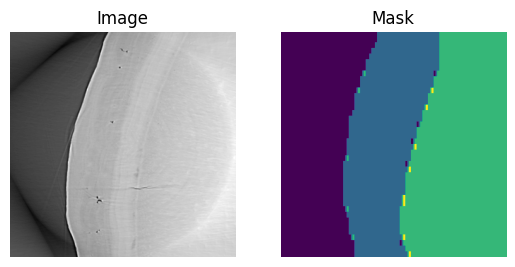

In [4]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(training_images[0], cmap="grey")
axes[1].imshow(training_masks[0])

for axis, title in zip(axes, ("Image", "Mask")):
    axis.axis("off")
    axis.set_title(title)

In [4]:
"""
Encode the labels and add this label to the data in the model; also compute class weights

The code here is a mess

"""
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# We'll need these later
train_masks_reshaped = np.array(training_masks).reshape(-1, 1)
train_masks_reshaped_encoded = LabelEncoder().fit_transform(
    train_masks_reshaped.ravel()
)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(
    *np.array(training_masks).shape
)

# Add another dimension to the training images. not entirely sure why
train_images = np.array(training_images)[..., np.newaxis]
train_masks = np.array(training_masks)[..., np.newaxis]

# Normalize images
train_images = train_images / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_masks, test_size=0.10, random_state=42
)

# Create a smaller subset for quick testing of models
X_train_small = X_train[: int(X_train.shape[0] * 0.8)]
y_train_small = y_train[: int(y_train.shape[0] * 0.8)]

print(
    f"Class values in the dataset are ... , {dict(zip(*np.unique(y_train, return_counts=True)))}; 0 is the background/few unlabeled"
)

# Convert the vector of labels to a one-hot encoded matrix
n_classes = len(np.unique(training_masks))
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape(
    (y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)
)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape(
    (y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes)
)

# Find class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_masks_reshaped_encoded),
    y=train_masks_reshaped_encoded,
)
print("Class weights are...:", class_weights)

2023-11-21 11:59:03.879466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 11:59:03.901514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 11:59:03.901542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 11:59:03.901555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 11:59:03.905815: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 11:59:03.906393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Class values in the dataset are ... , {0: 276856, 1: 284064, 2: 359144, 3: 1536}; 0 is the background/few unlabeled
Class weights are...: [  0.8270016    0.81738997   0.64087159 142.22222222]


In [5]:
"""
Define the uNet

"""
from cementum import unet

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model = unet.my_unet(
    n_classes=n_classes,
    IMG_HEIGHT=IMG_HEIGHT,
    IMG_WIDTH=IMG_WIDTH,
    IMG_CHANNELS=IMG_CHANNELS,
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 320, 320, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 320, 320, 16)         2320      ['dropout[0][0]']             
                                                                                              

2023-11-21 11:59:05.252971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-21 11:59:05.253212: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


                                                                                                  
 conv2d_9 (Conv2D)           (None, 20, 20, 256)          590080    ['dropout_4[0][0]']           
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 40, 40, 128)          131200    ['conv2d_9[0][0]']            
 anspose)                                                                                         
                                                                                                  
 concatenate (Concatenate)   (None, 40, 40, 256)          0         ['conv2d_transpose[0][0]',    
                                                                     'conv2d_7[0][0]']            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 40, 40, 128)          295040    ['concatenate[0][0]']         
          

In [6]:
history = model.fit(
    X_train,
    y_train_cat,
    batch_size=16,
    verbose=1,
    epochs=20,
    validation_data=(X_test, y_test_cat),
    # class_weight=class_weights,
    shuffle=False,
)
model.save("cementum_test.hdf5")

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 1.5444 - accuracy: 0.2017 - val_loss: 1.4192 - val_accuracy: 0.2972
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 1.4009 - accuracy: 0.3080 - val_loss: 1.3538 - val_accuracy: 0.2881
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 1.3104 - accuracy: 0.3134 - val_loss: 1.2750 - val_accuracy: 0.2869
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 1.2420 - accuracy: 0.3144 - val_loss: 1.2146 - val_accuracy: 0.2855
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 1.1900 - accuracy: 0.3202 - val_loss: 1.1714 - val_accuracy: 0.3106
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 1.1496 - accuracy: 0.3304 - val_loss: 1.1343 - val_accuracy: 0.3186
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 1.1264 - accuracy: 0.3418 - val_loss: 1.1078 - val_accuracy: 0.3852
Epoch 8/20
1/1 [=========================

/home/mh19137/miniforge3/envs/cementum/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


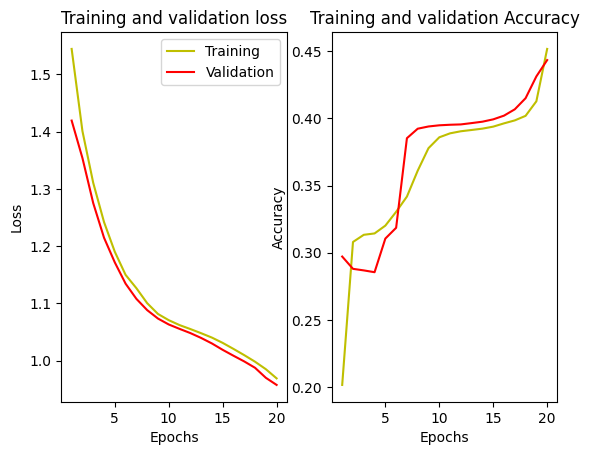

In [7]:
"""
Plot the loss and validation accuracy at each epoch

"""
loss = history.history["loss"]
val_loss = history.history["val_loss"]

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2)
axes[0].plot(epochs, loss, "y", label="Training")
axes[0].plot(epochs, val_loss, "r", label="Validation")
axes[0].set_title("Training and validation loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(epochs, acc, "y", label="Training")
axes[1].plot(epochs, val_acc, "r", label="Validation")
axes[1].set_title("Training and validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[0].legend()

1/1 [==============================] - 0s 210ms/step
IoU for class 0 is:  0.15356149
IoU for class 1 is:  0.0040880013
IoU for class 2 is:  0.42626217
IoU for class 3 is:  0.0


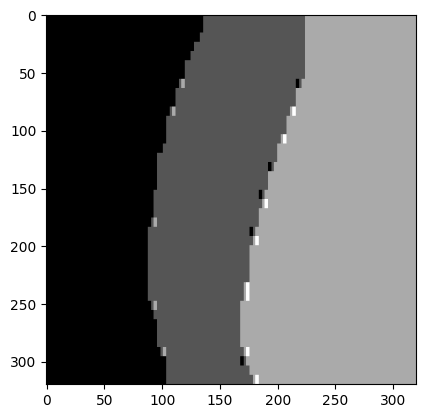

In [8]:
"""
Calculate intersection over union for each class

"""
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:, :, :, 0], model.predict(X_test).argmax(axis=3))


def calculate_iou(values, class_idx):
    iou = values[class_idx, class_idx] / (
        values[class_idx, :].sum()
        + values[:, class_idx].sum()
        - values[class_idx, class_idx]
    )
    return iou


values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

for i in range(n_classes):
    class_iou = calculate_iou(values, i)
    print(f"IoU for class {i} is: ", class_iou)

plt.imshow(train_images[0, :, :, 0], cmap="gray")
plt.imshow(train_masks[0], cmap="gray")

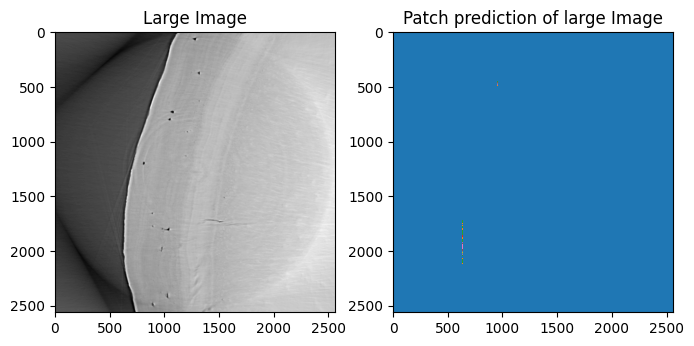

In [9]:
"""
Apply to one of the large images

"""
from patchify import patchify, unpatchify
from keras.utils import normalize

large_images = np.asarray(full_size_images)
large_image = large_images[1, :, :]

# This will split the image into small images of shape [3,3]
patches = patchify(
    large_image, (IMG_HEIGHT, IMG_WIDTH), step=IMG_WIDTH
)  # Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i, j, :, :]
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1), 2)
        single_patch_input = np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = model.predict(single_patch_input, verbose=0)
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0, :, :]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(
    predicted_patches, (patches.shape[0], patches.shape[1], IMG_HEIGHT, IMG_WIDTH)
)

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title("Large Image")
plt.imshow(large_image, cmap="gray")
plt.subplot(222)
plt.title("Patch prediction of large Image")
plt.imshow(reconstructed_image, cmap="tab10")
plt.show()